In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('/kaggle/working/notebook/experiment/v1/')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'PAN'
    backbone = 'timm-mobilenetv3_small_075'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 25

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:200]
    valid_df=valid_df[:200]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

# show_dataset(112, dataset_train)


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  PAN
backbone:  timm-mobilenetv3_small_075


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/25  Mem : 0.721GB  LR : 1.00E-04  Loss: 0.8281: 100%|██████████| 642/642
Val Loss: 0.8673: 100%|██████████| 58/58 [02:33<00:00,  2.65s/it]               


FBeta : 0.2230	thresh : 0.17	SAVED MODEL



Epoch 1/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.6521: 100%|██████████| 642/642
Val Loss: 0.7430: 100%|██████████| 58/58 [02:19<00:00,  2.40s/it]               


FBeta : 0.3287	thresh : 0.11	SAVED MODEL



Epoch 2/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.6073: 100%|██████████| 642/642
Val Loss: 0.7176: 100%|██████████| 58/58 [02:35<00:00,  2.68s/it]               


FBeta : 0.3460	thresh : 0.09	SAVED MODEL



Epoch 3/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5852: 100%|██████████| 642/642
Val Loss: 0.7040: 100%|██████████| 58/58 [02:22<00:00,  2.47s/it]               


FBeta : 0.3539	thresh : 0.17	SAVED MODEL



Epoch 4/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5745: 100%|██████████| 642/642
Val Loss: 0.7062: 100%|██████████| 58/58 [02:31<00:00,  2.61s/it]               


FBeta : 0.3626	thresh : 0.07	SAVED MODEL



Epoch 5/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5619: 100%|██████████| 642/642
Val Loss: 0.6892: 100%|██████████| 58/58 [02:25<00:00,  2.50s/it]               


FBeta : 0.3757	thresh : 0.09	SAVED MODEL



Epoch 6/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5523: 100%|██████████| 642/642
Val Loss: 0.6825: 100%|██████████| 58/58 [02:21<00:00,  2.44s/it]               


FBeta : 0.3703	thresh : 0.33



Epoch 7/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5444: 100%|██████████| 642/642
Val Loss: 0.6691: 100%|██████████| 58/58 [02:27<00:00,  2.55s/it]               


FBeta : 0.3859	thresh : 0.29	SAVED MODEL



Epoch 8/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5368: 100%|██████████| 642/642
Val Loss: 0.6664: 100%|██████████| 58/58 [02:17<00:00,  2.38s/it]               


FBeta : 0.3920	thresh : 0.15	SAVED MODEL



Epoch 9/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5271: 100%|██████████| 642/642
Val Loss: 0.6592: 100%|██████████| 58/58 [02:30<00:00,  2.59s/it]               


FBeta : 0.3948	thresh : 0.33	SAVED MODEL



Epoch 10/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5201: 100%|██████████| 642/64
Val Loss: 0.6581: 100%|██████████| 58/58 [02:17<00:00,  2.38s/it]               


FBeta : 0.3962	thresh : 0.19	SAVED MODEL



Epoch 11/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5155: 100%|██████████| 642/64
Val Loss: 0.6572: 100%|██████████| 58/58 [02:31<00:00,  2.62s/it]               


FBeta : 0.3965	thresh : 0.15	SAVED MODEL



Epoch 12/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5087: 100%|██████████| 642/64
Val Loss: 0.6509: 100%|██████████| 58/58 [02:12<00:00,  2.29s/it]               


FBeta : 0.4051	thresh : 0.15	SAVED MODEL



Epoch 13/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.5024: 100%|██████████| 642/64
Val Loss: 0.6455: 100%|██████████| 58/58 [02:31<00:00,  2.62s/it]               


FBeta : 0.4067	thresh : 0.31	SAVED MODEL



Epoch 14/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4972: 100%|██████████| 642/64
Val Loss: 0.6633: 100%|██████████| 58/58 [02:13<00:00,  2.30s/it]               


FBeta : 0.4004	thresh : 0.07



Epoch 15/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4912: 100%|██████████| 642/64
Val Loss: 0.6461: 100%|██████████| 58/58 [02:32<00:00,  2.62s/it]               


FBeta : 0.4061	thresh : 0.27



Epoch 16/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4848: 100%|██████████| 642/64
Val Loss: 0.6408: 100%|██████████| 58/58 [02:14<00:00,  2.31s/it]               


FBeta : 0.4090	thresh : 0.25	SAVED MODEL



Epoch 17/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4787: 100%|██████████| 642/64
Val Loss: 0.6450: 100%|██████████| 58/58 [02:34<00:00,  2.66s/it]               


FBeta : 0.4050	thresh : 0.31



Epoch 18/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4756: 100%|██████████| 642/64
Val Loss: 0.6453: 100%|██████████| 58/58 [02:13<00:00,  2.31s/it]               


FBeta : 0.4063	thresh : 0.21



Epoch 19/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4711: 100%|██████████| 642/64
Val Loss: 0.6448: 100%|██████████| 58/58 [02:31<00:00,  2.61s/it]               


FBeta : 0.4070	thresh : 0.13



Epoch 20/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4665: 100%|██████████| 642/64
Val Loss: 0.6494: 100%|██████████| 58/58 [02:20<00:00,  2.42s/it]               


FBeta : 0.4052	thresh : 0.13



Epoch 21/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4639: 100%|██████████| 642/64
Val Loss: 0.6490: 100%|██████████| 58/58 [02:31<00:00,  2.61s/it]               


FBeta : 0.4066	thresh : 0.13



Epoch 22/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4625: 100%|██████████| 642/64
Val Loss: 0.6533: 100%|██████████| 58/58 [02:21<00:00,  2.44s/it]               


FBeta : 0.4043	thresh : 0.07



Epoch 23/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4584: 100%|██████████| 642/64
Val Loss: 0.6476: 100%|██████████| 58/58 [02:28<00:00,  2.56s/it]               


FBeta : 0.4053	thresh : 0.09



Epoch 24/25  Mem : 0.856GB  LR : 1.00E-03  Loss: 0.4566: 100%|██████████| 642/64
Val Loss: 0.6511: 100%|██████████| 58/58 [02:25<00:00,  2.51s/it]               


FBeta : 0.4038	thresh : 0.11

{"status":200,"message":"ok"}

In [9]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  PAN
backbone:  timm-mobilenetv3_small_075
0.4090


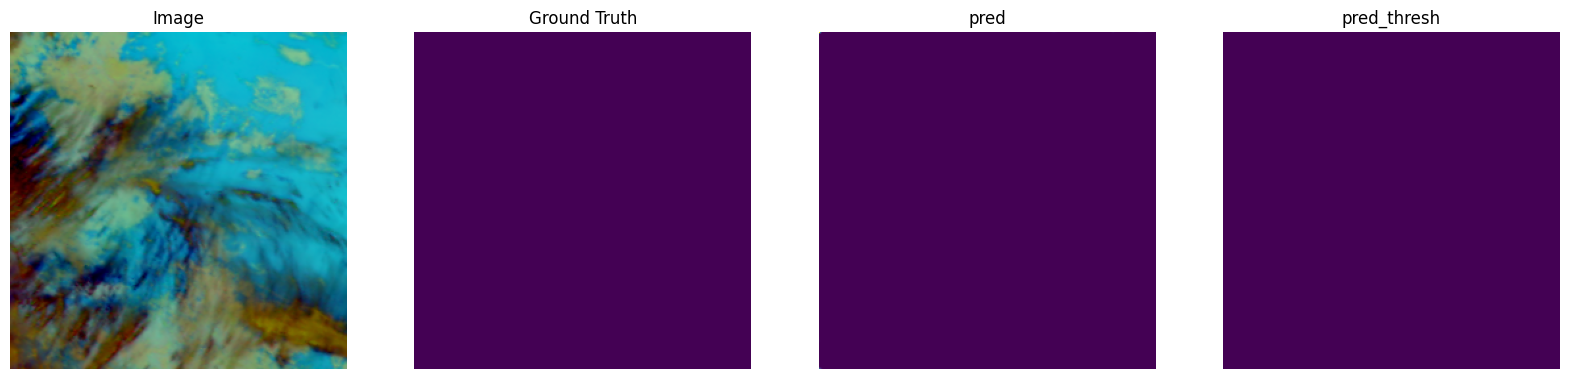

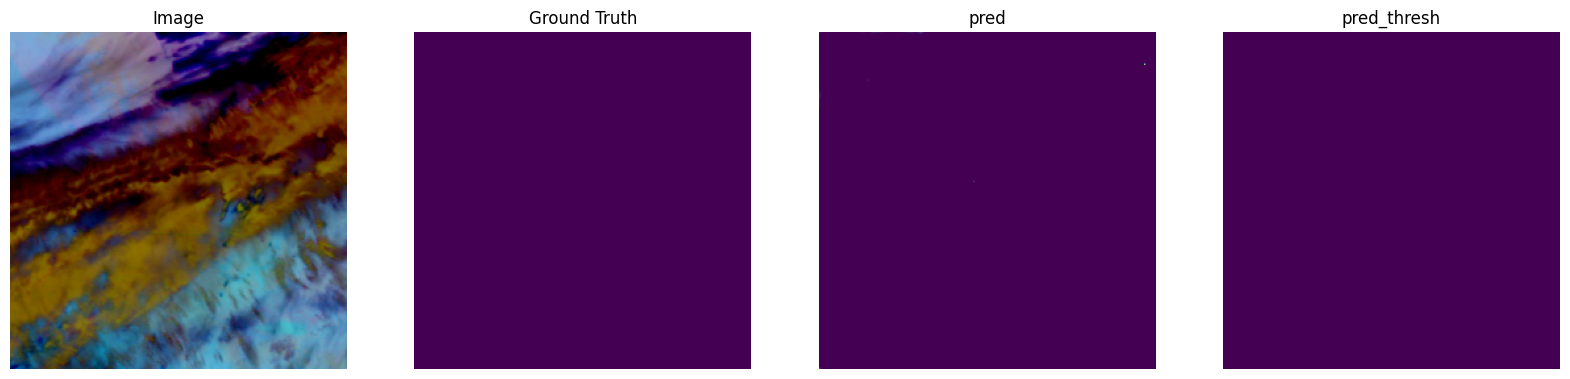

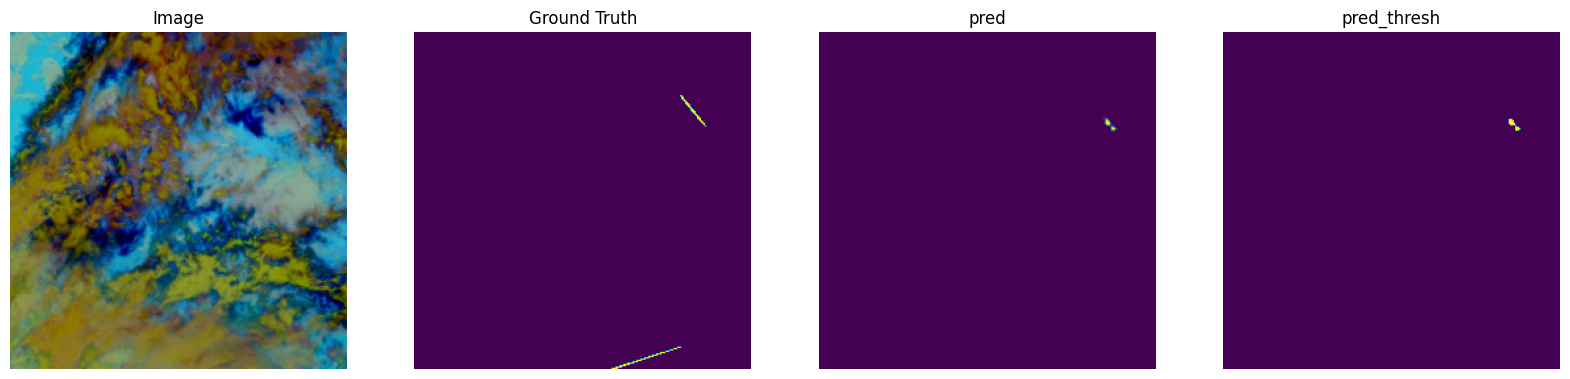

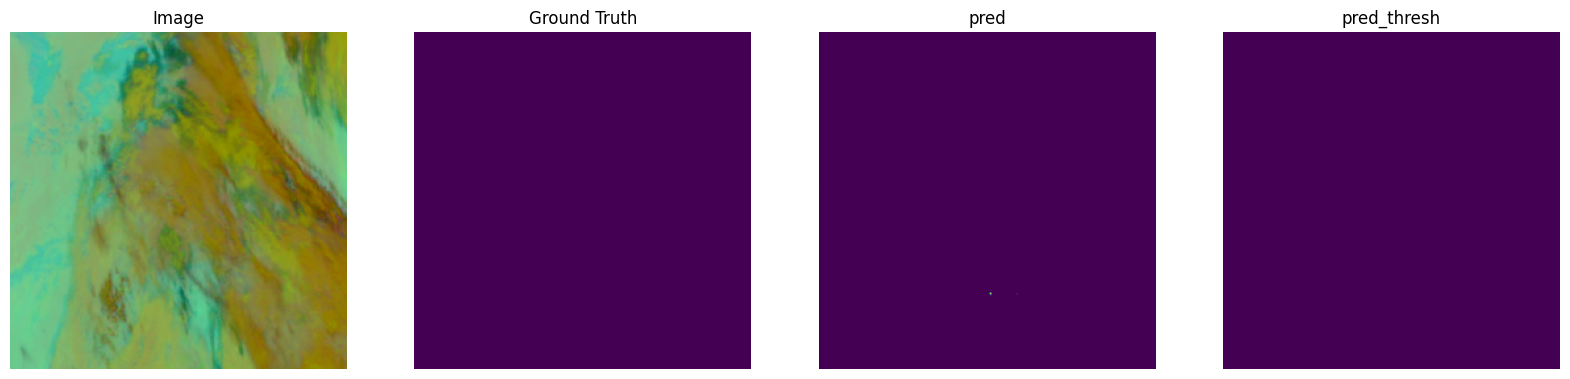

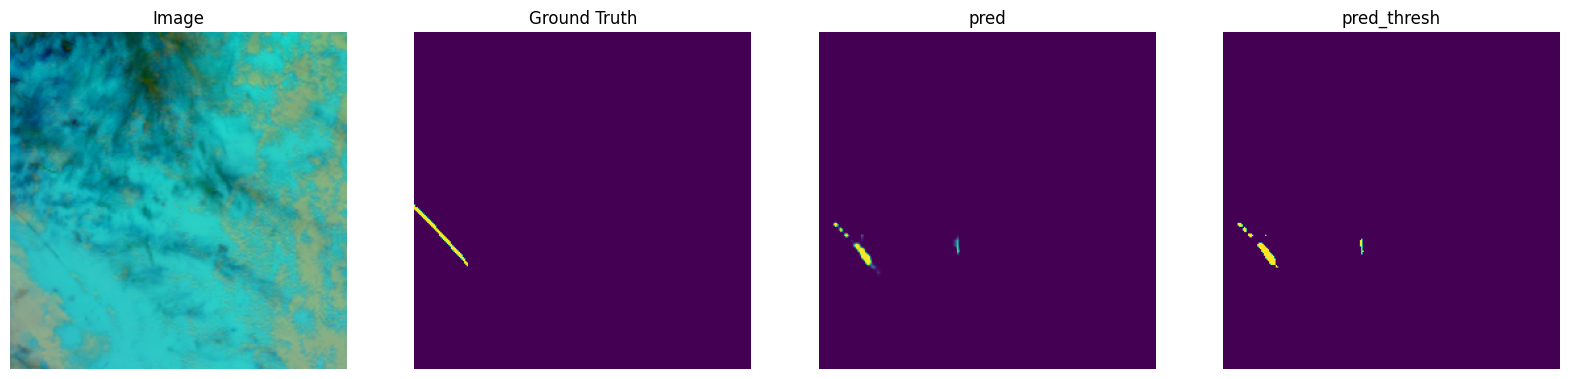

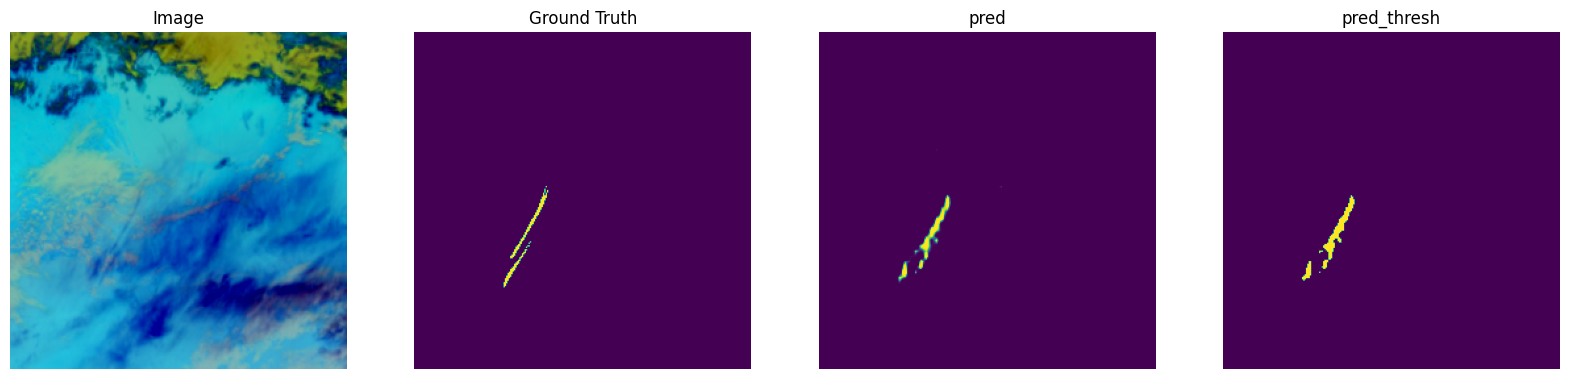

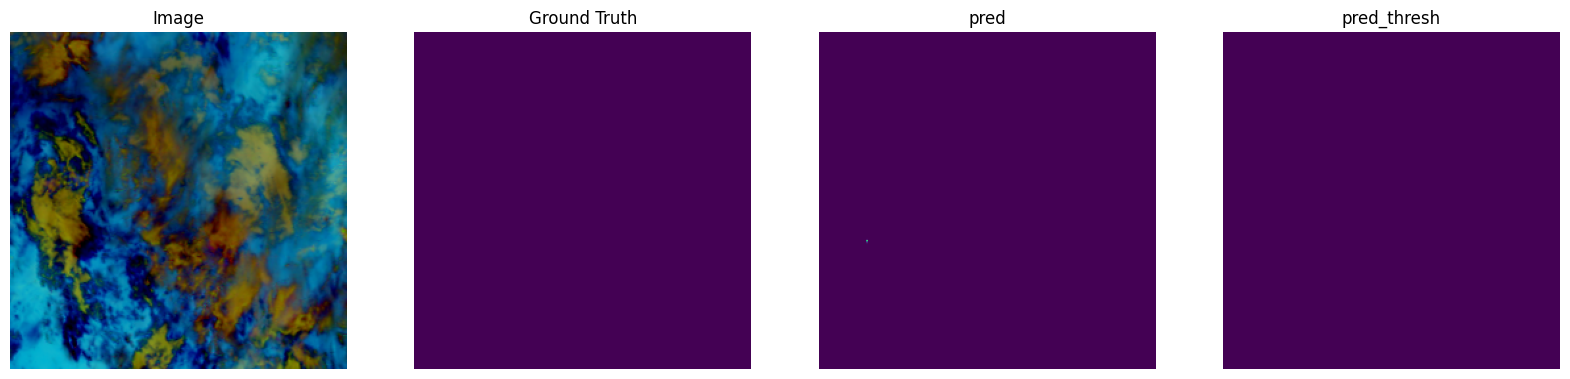

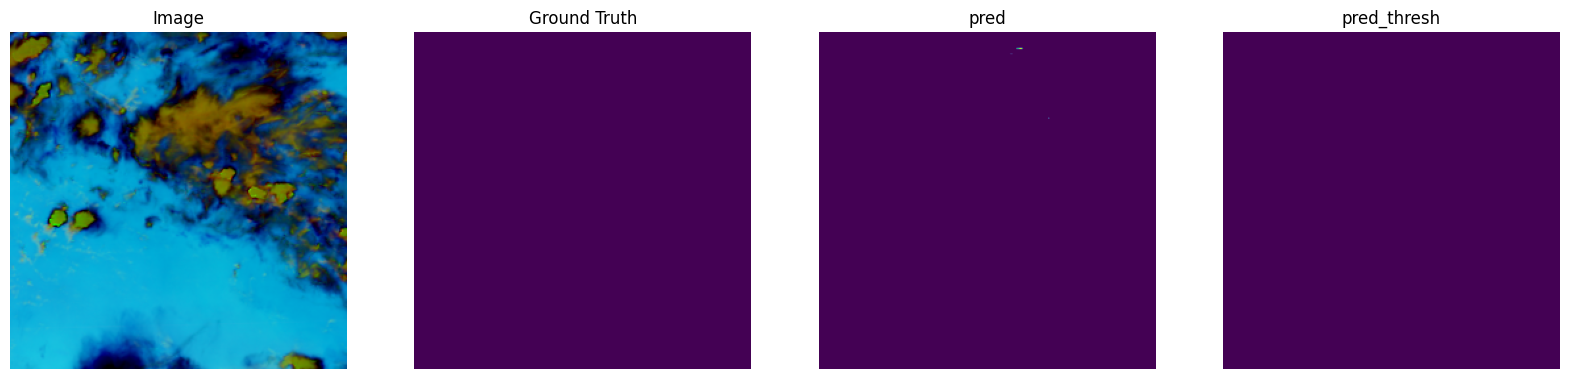

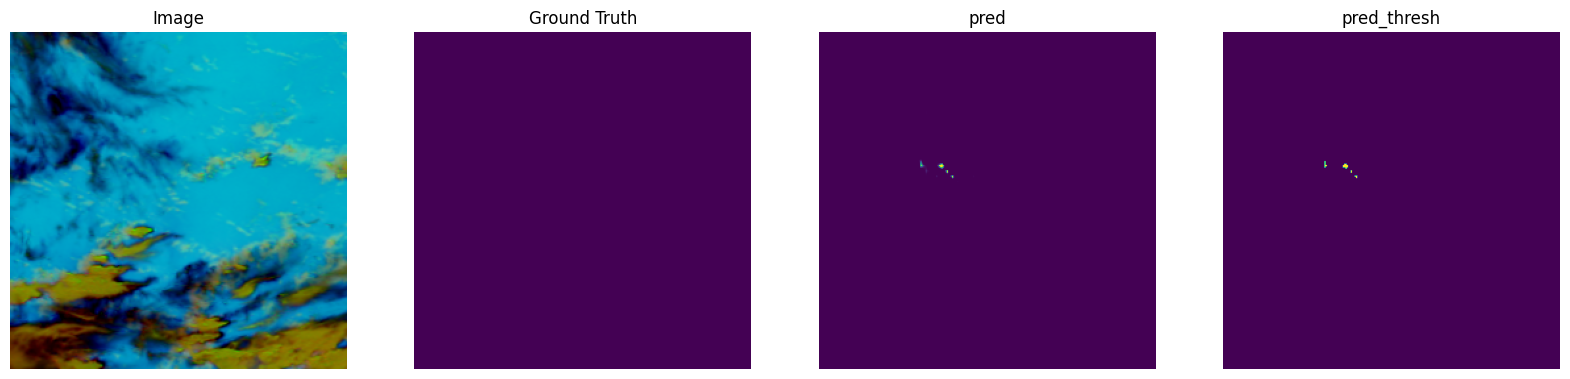

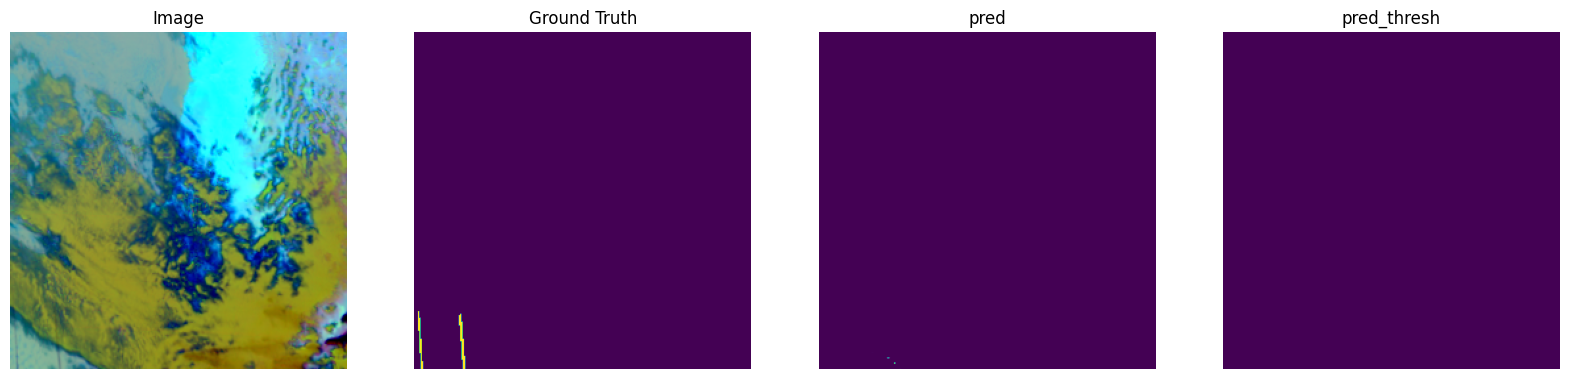

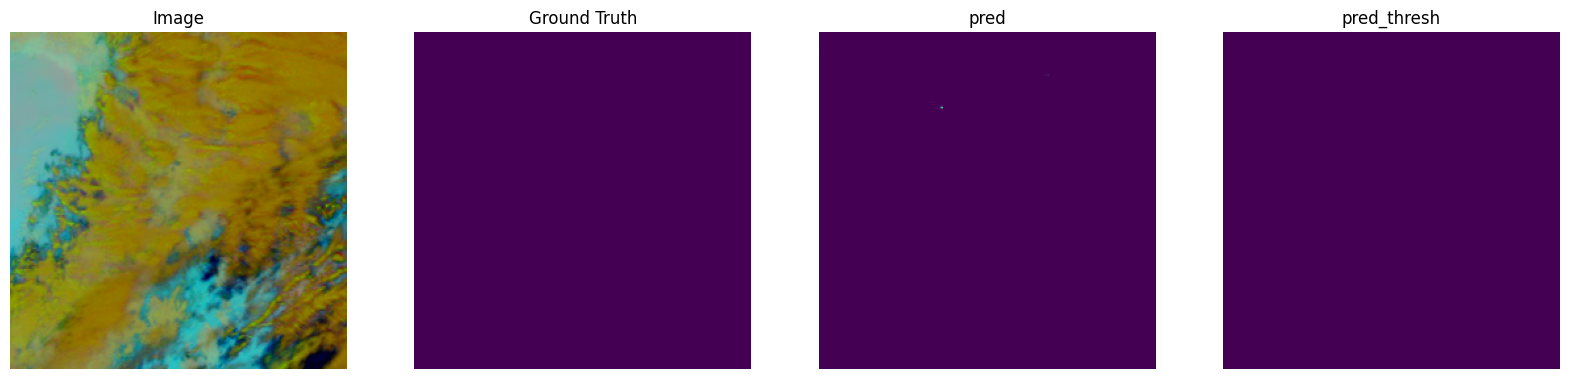

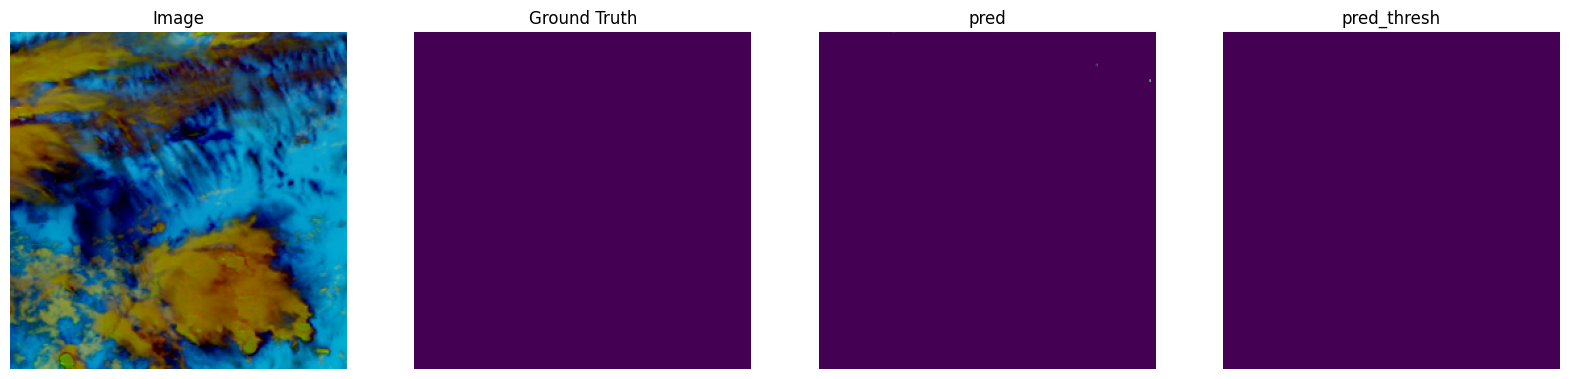

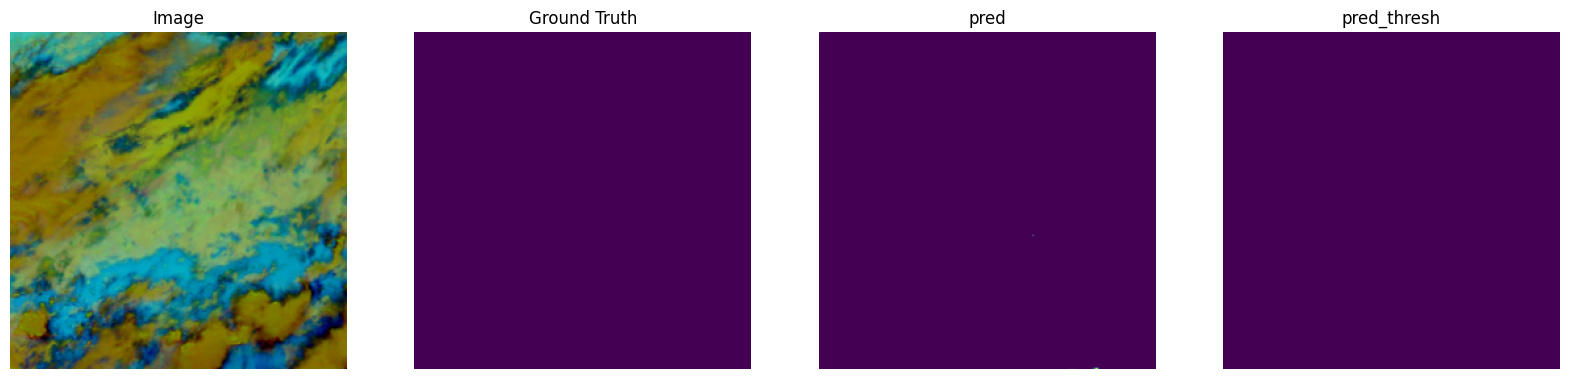

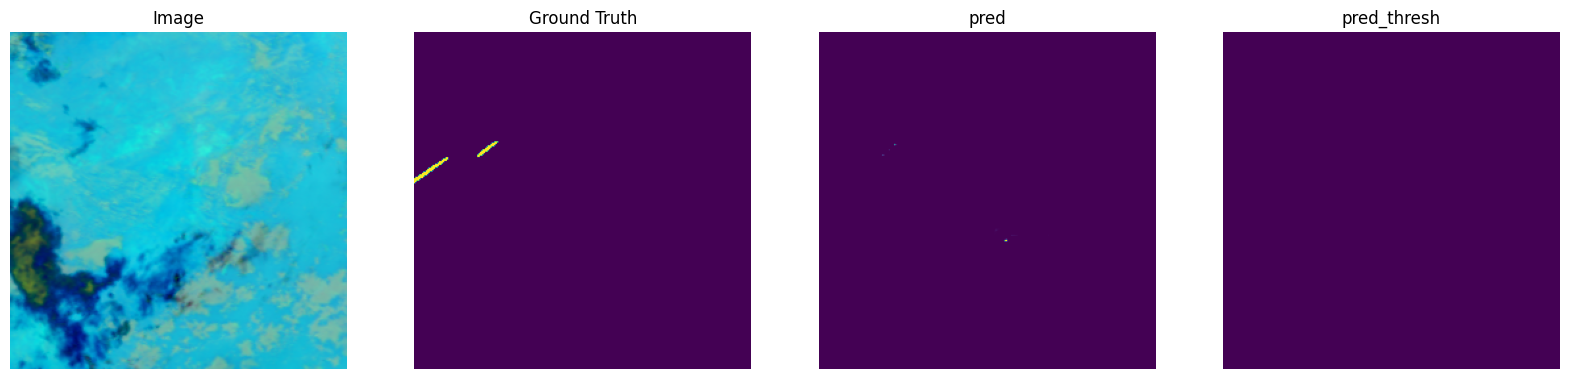

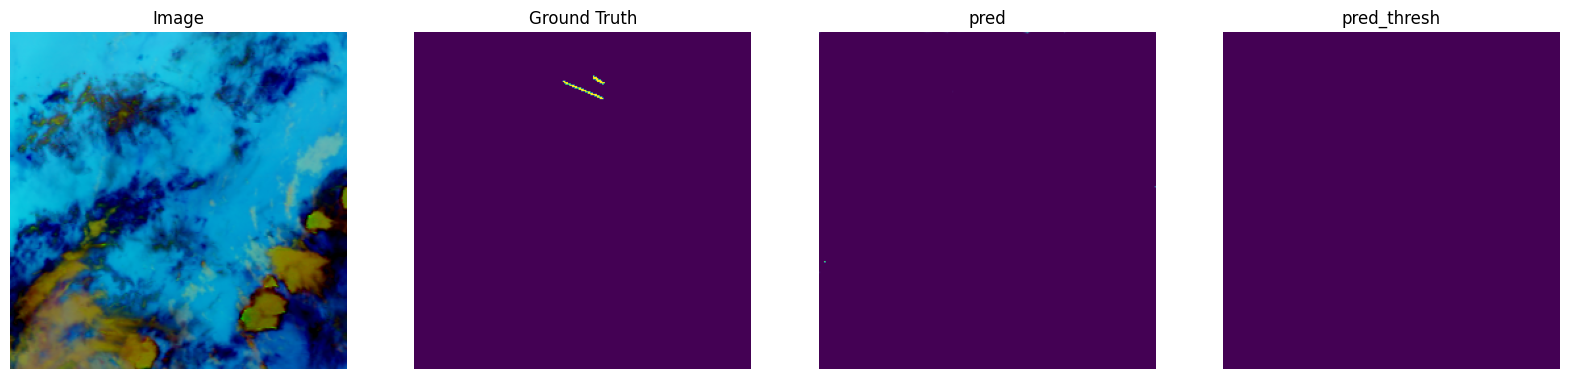

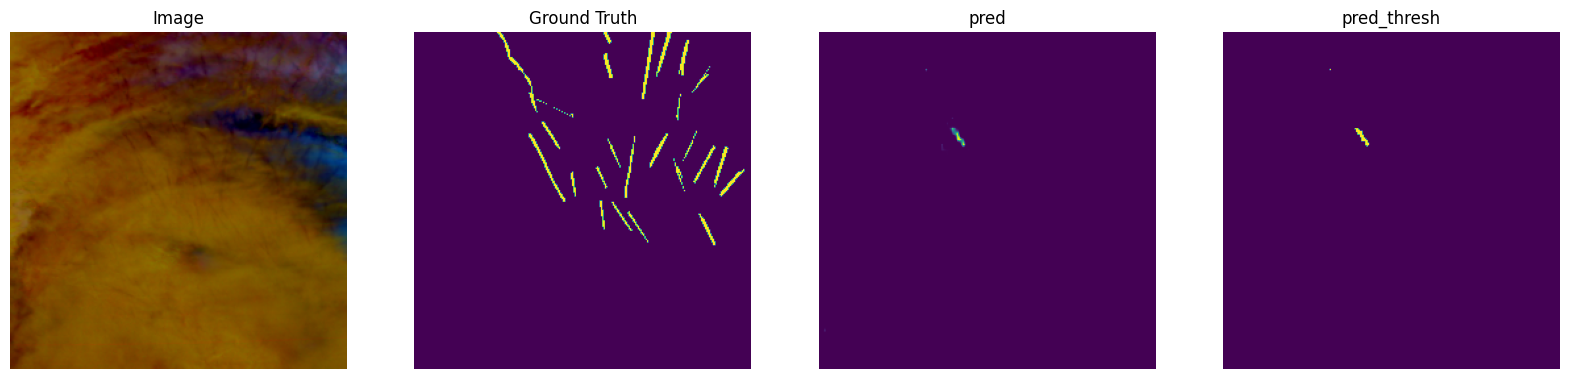

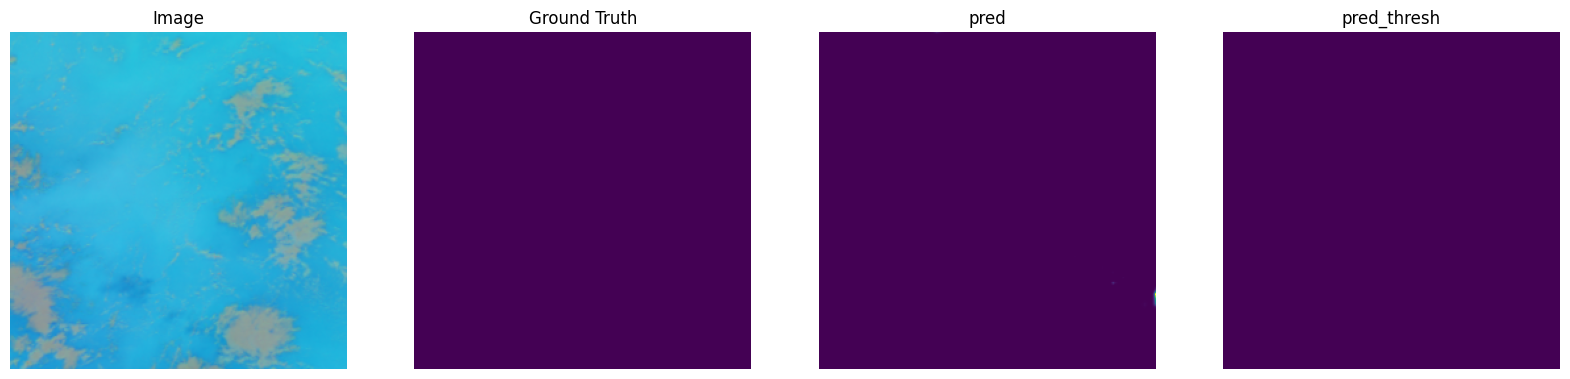

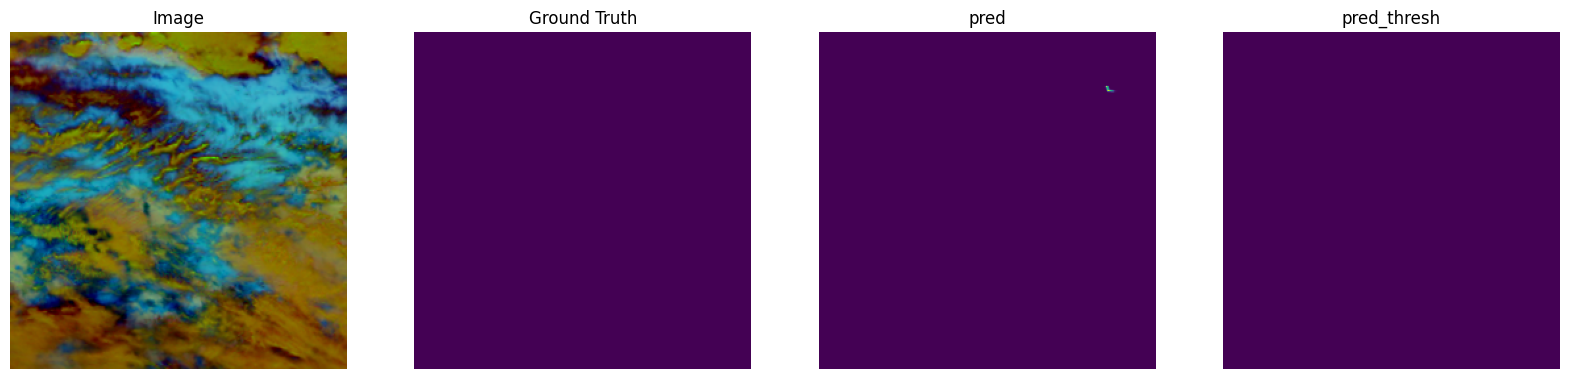

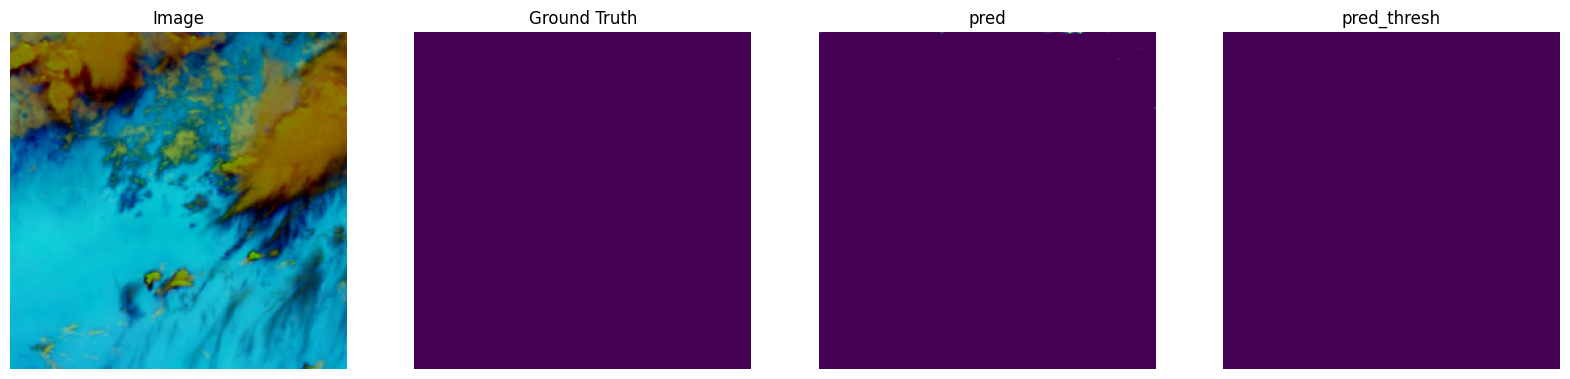

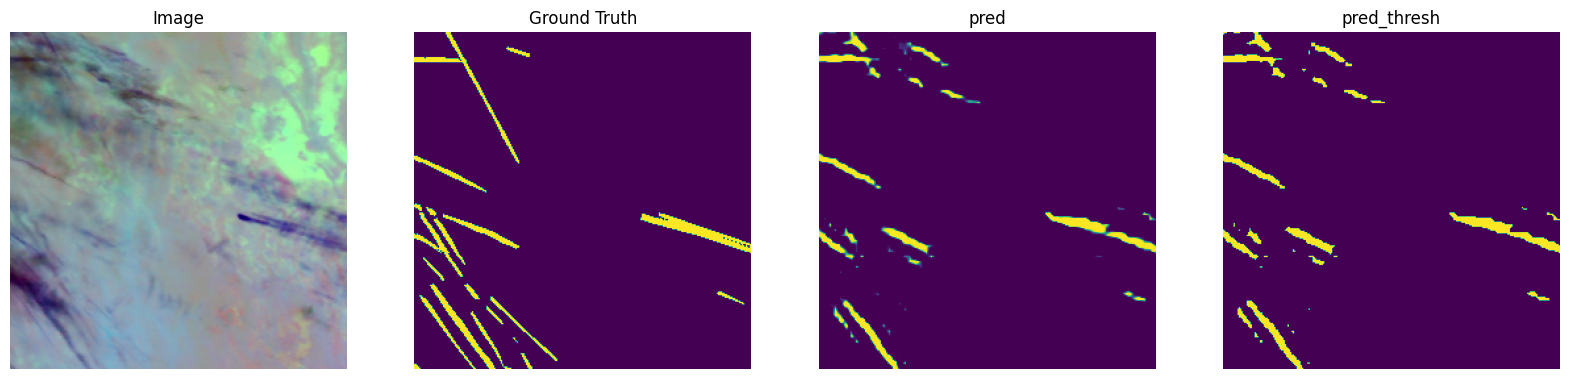

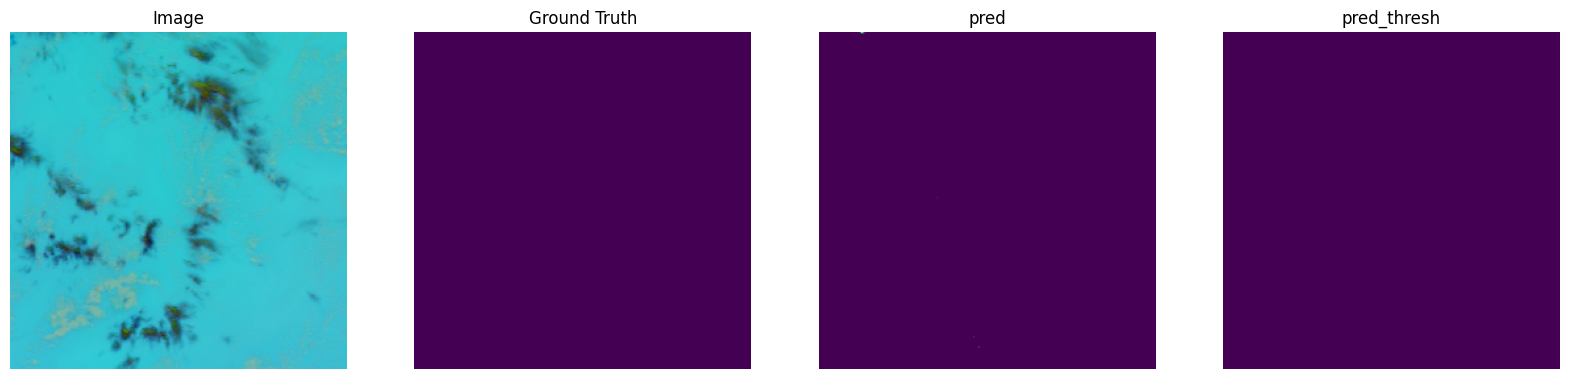

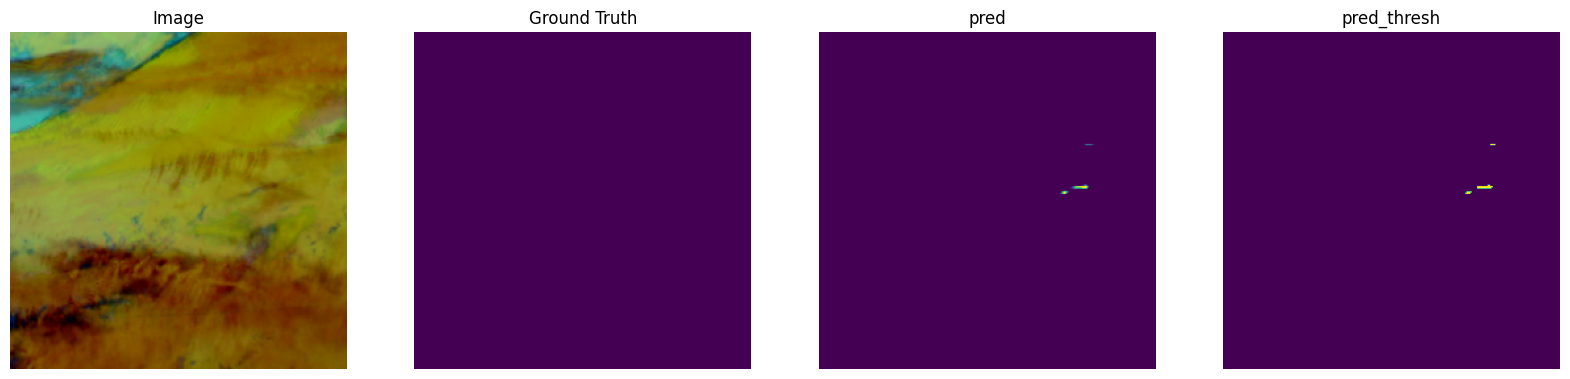

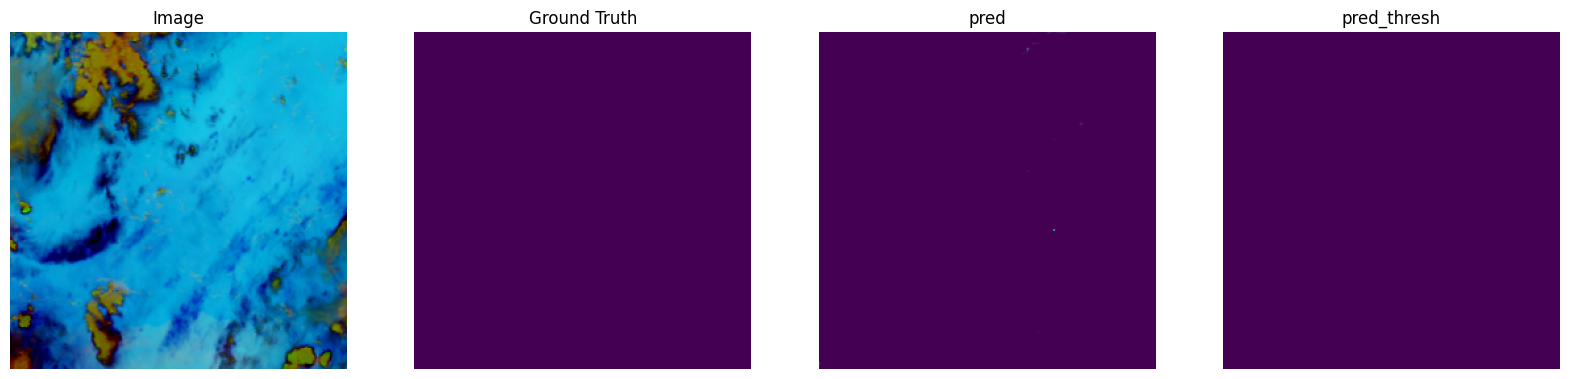

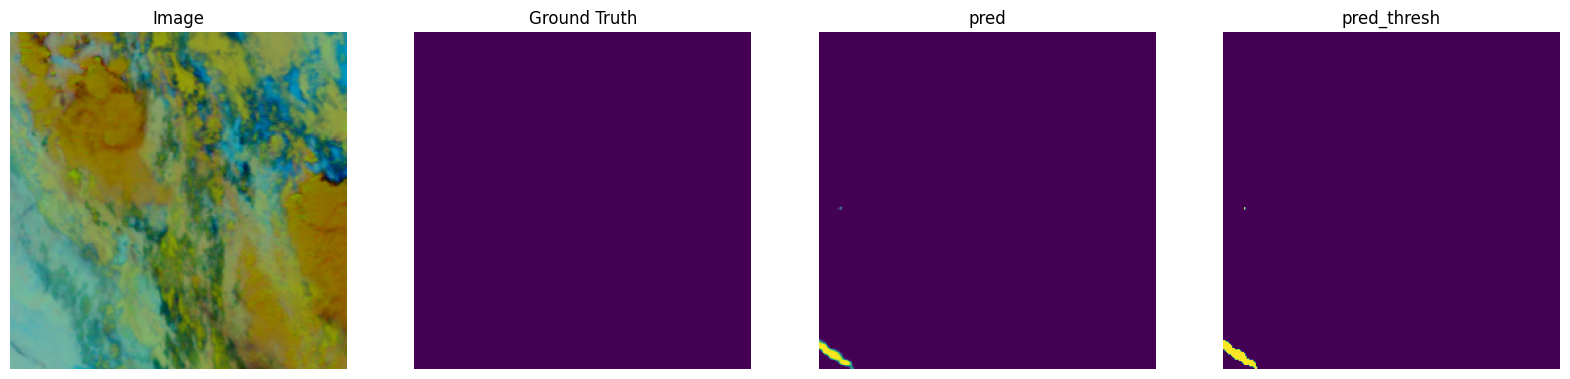

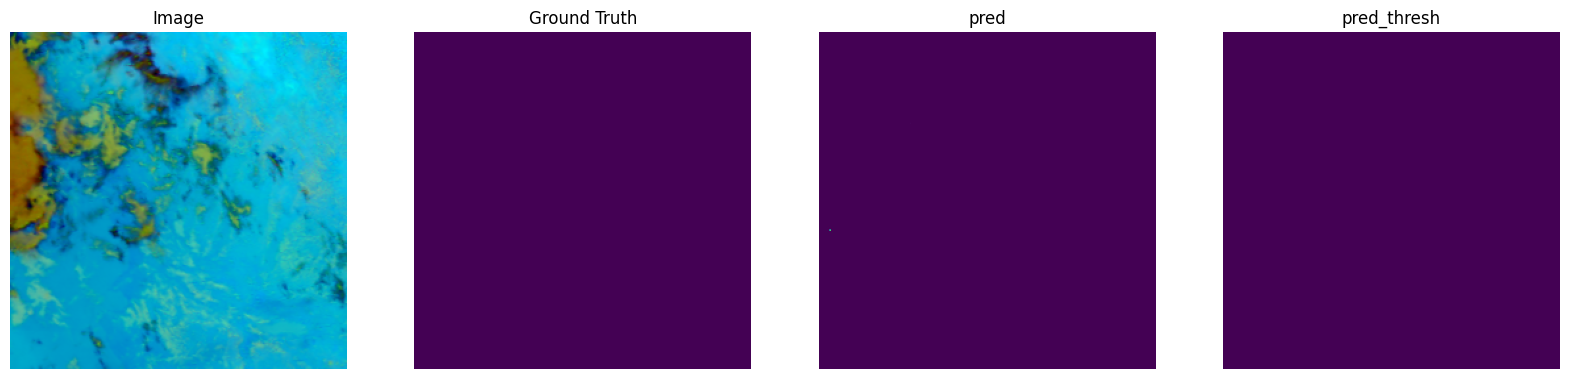

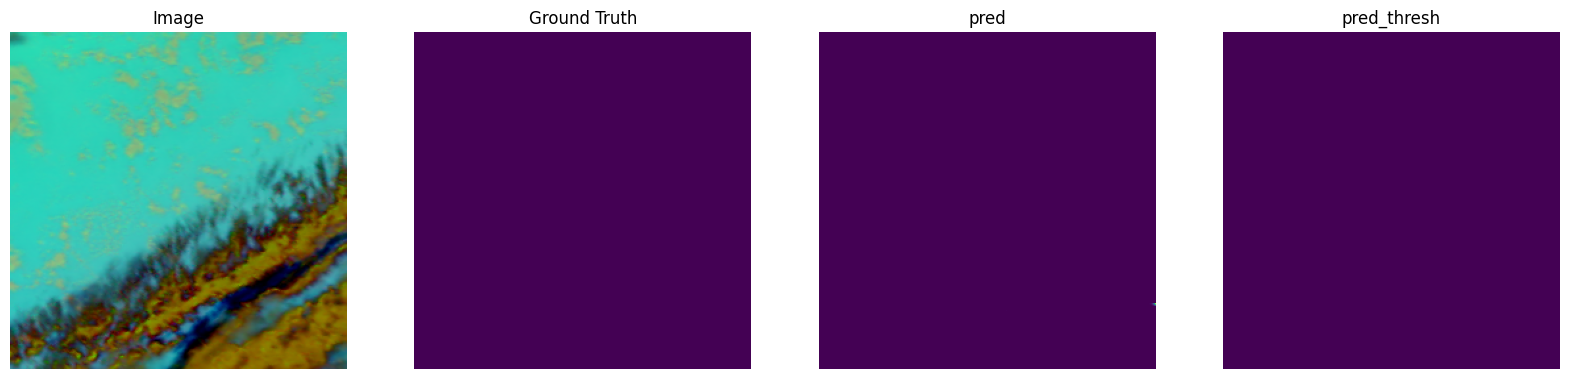

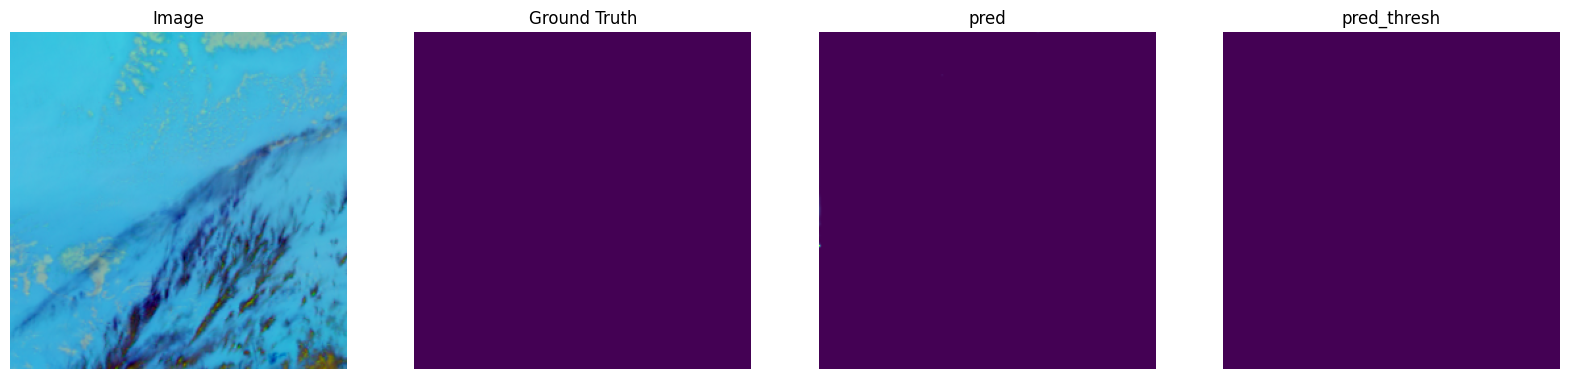

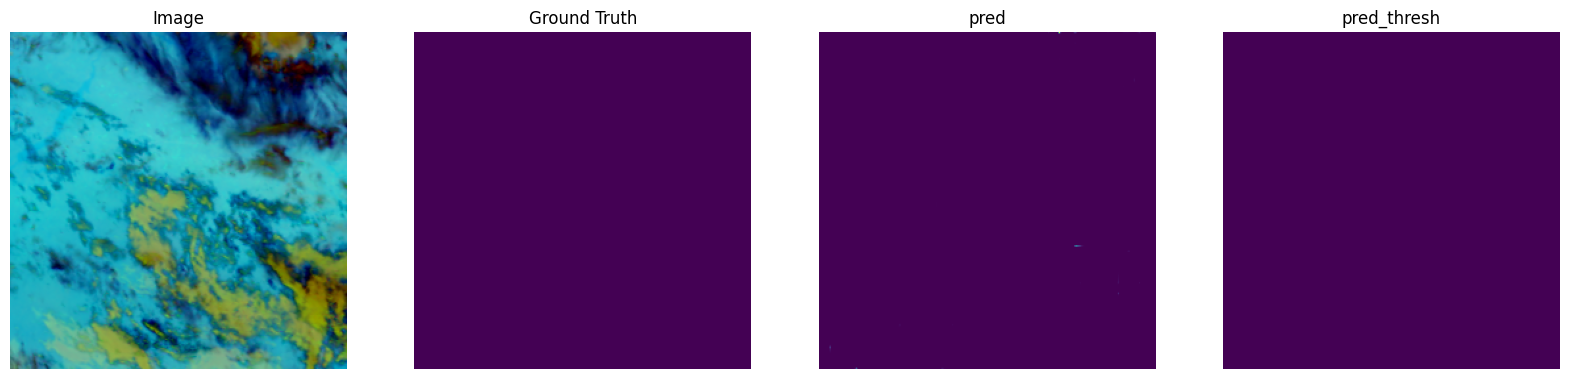

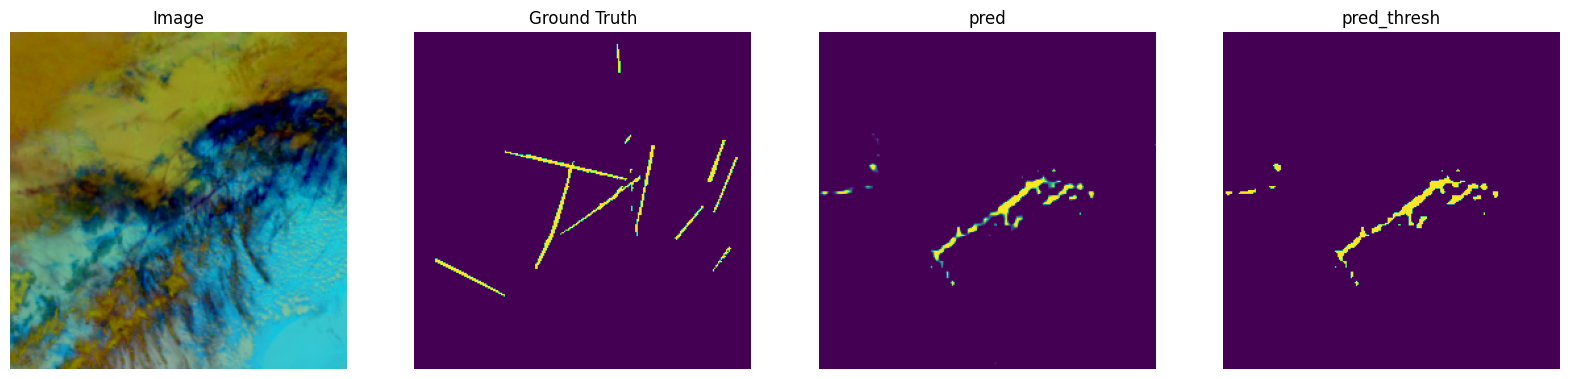

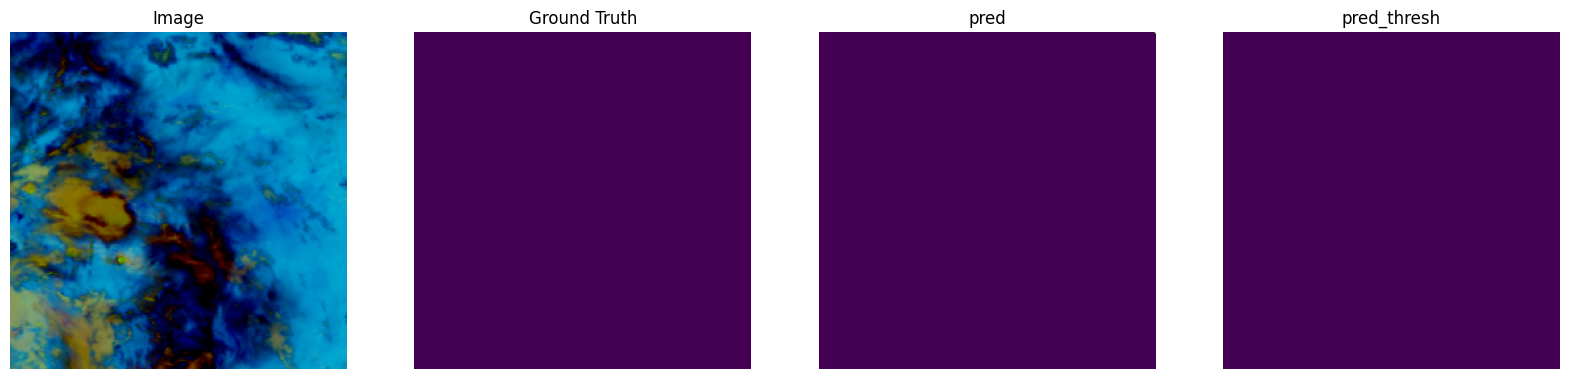

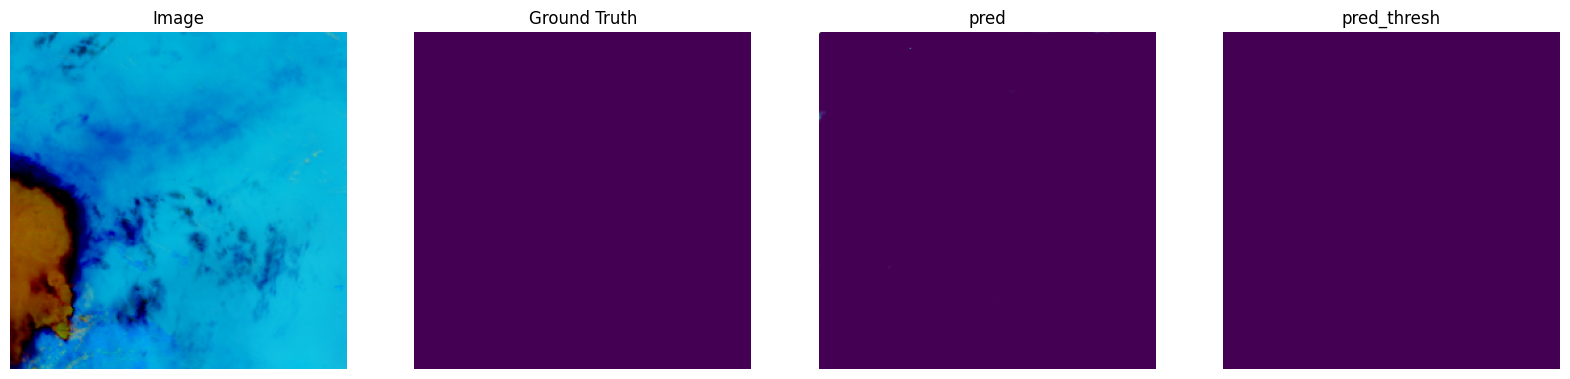

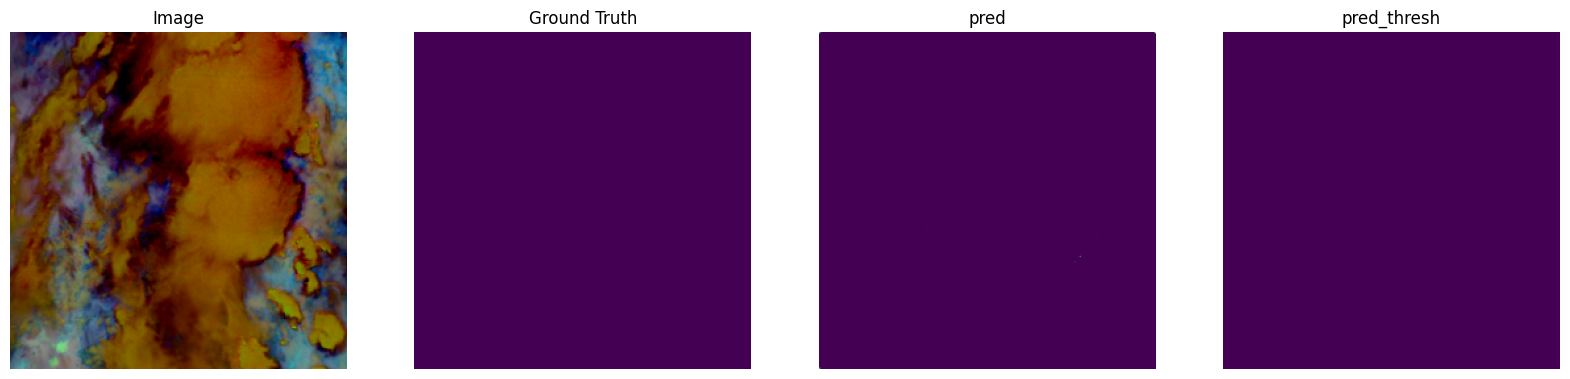

In [10]:
for i, (images, masks) in enumerate(dataloader_valid):
    if i!=1: continue
    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
    images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
    for num in range(CFG.valid_batch_size):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        axes = axes.flatten()
        axes[0].imshow(images[num].permute(1,2,0))
        axes[0].axis('off')
        axes[0].set_title('Image')
        axes[1].imshow(masks[num].permute(1,2,0))
        axes[1].axis('off')
        axes[1].set_title('Ground Truth')
        axes[2].imshow(preds[num].permute(1,2,0))
        axes[2].axis('off')
        axes[2].set_title('pred')
        axes[3].imshow((preds[num]>thresh).permute(1,2,0))
        axes[3].axis('off')
        axes[3].set_title('pred_thresh')
    break